# This notebook
1. Selects the patient, trial, variable
2. Load the corresponding DataFrame
3. Preprocessing options: Raw, Downsampled, Segmented, Normalized 


In [13]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.io as pio
from matplotlib.widgets import Slider
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from Data_loader import base_folders  
from pipeline import segment_downsamp 
from segment_utils import segment_cycles
from downsample import downsample_df

In [10]:
# Trial parameters 
group_code = "G01"
patient_id = "S002"
day = "D01"
block = "B01"
trial = "T01"
signal_col = "Ankle Dorsiflexion RT (deg)"
min_length = 20
downsample_factor = 4
show_raw = True
show_downsampled = True
show_segmented = True
save_plots = True


In [18]:
#Function to plot trial 
def plot_trial(
    patient_id,
    group_code,
    day,
    block,
    trial,
    signal_col=signal_col,
    min_length=min_length,
    downsample_factor=downsample_factor,
    show_raw=True,
    show_downsampled=False,
    show_segmented=False,
    save_plots=False,
    results_dir="Results visualization"
    
):
    if save_plots:
        project_root = os.getcwd()
        results_folder = os.path.join(project_root, results_dir)
        os.makedirs(results_folder, exist_ok=True)


    base_folder = os.path.abspath(base_folders[group_code])
    patient_folder = os.path.join(base_folder, patient_id)
    fname = f"{patient_id}_{group_code}_{day}_{block}_{trial}.csv"
    path = os.path.join(patient_folder, fname)
    print(f"[INFO] File Path: {path}")
    if not os.path.exists(path):
        print(f"[ERROR] File not found: {path}")
        return
    
    df = pd.read_csv(path)
    signal = df[signal_col].interpolate().values
    

        
    if show_raw:
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=signal, mode='lines', name='Raw', line=dict(color='gray')))
        
        fig.update_layout(
            title=f"{patient_id}_{group_code}_{day}_{block}_{trial} | {signal_col} (Raw)",
            xaxis_title='Sample',
            yaxis_title='Angle (deg)',
            xaxis=dict(
                rangeslider=dict(visible=True),  # scroll
                type="linear"
            )
        )
        
        if save_plots:
            fname_raw = f"{patient_id}_{group_code}_{day}_{block}_{trial}_{signal_col}_raw.html"
            path_raw = os.path.join(results_folder, fname_raw)
            pio.write_html(fig, file=path_raw, auto_open=False)
        
        fig.show()
    
    # Downsampled
    if show_downsampled:
        try:
            signal_ds_df = downsample_df(df, rate=downsample_factor, cols=[signal_col], zero_phase=False)
            signal_ds = signal_ds_df[signal_col].values  
        
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=signal_ds, mode='lines', name='Downsampled', line=dict(color='orange')))
        
            fig.update_layout(
                title=f"{patient_id}_{group_code}_{day}_{block}_{trial} | {signal_col} (Downsampled)",
                xaxis_title='Sample',
                yaxis_title='Angle (deg)',
                xaxis=dict(
                    rangeslider=dict(visible=True),  # Scroll horizontal abajo
                    type="linear"
                )
            )
        
            if save_plots:
                fname_ds = f"{patient_id}_{group_code}_{day}_{block}_{trial}_{signal_col}_downsampled.html"
                path_ds = os.path.join(results_folder, fname_ds)
                pio.write_html(fig, file=path_ds, auto_open=False)
        
            fig.show()
        
        except Exception as e:
            print(f"[WARN] Downsampling failed: {e}")
    
    # Cycles segmented and normalized
    if show_segmented:
        cycles = segment_cycles(df)
        if not cycles:
            print("Not enough cycles found for segmentation.")
        else:
            fig = go.Figure()
            for idx, c in enumerate(cycles):
                sig = c[signal_col]
                fig.add_trace(go.Scatter(
                    y=sig.values,
                    mode='lines',
                    name=f'Cycle {idx+1}',
                    opacity=0.5
                ))

            fig.update_layout(
                title=f"{patient_id}_{group_code}_{day}_{block}_{trial} | {signal_col} (Segmented)",
                xaxis_title='Sample (resampled)',
                yaxis_title='Angle (deg)',
                xaxis=dict(
                    rangeslider=dict(visible=True),
                    type='linear'
                )
            )

            if save_plots:
                fname_seg = f"{patient_id}_{group_code}_{day}_{block}_{trial}_{signal_col}_segmented.html"
                path_seg = os.path.join(results_folder, fname_seg)
                pio.write_html(fig, file=path_seg, auto_open=False)

            fig.show()

[INFO] File Path: /home/dmartinez/Gait-Stability/young adults (19–35 years old)/S002/S002_G01_D01_B01_T01.csv


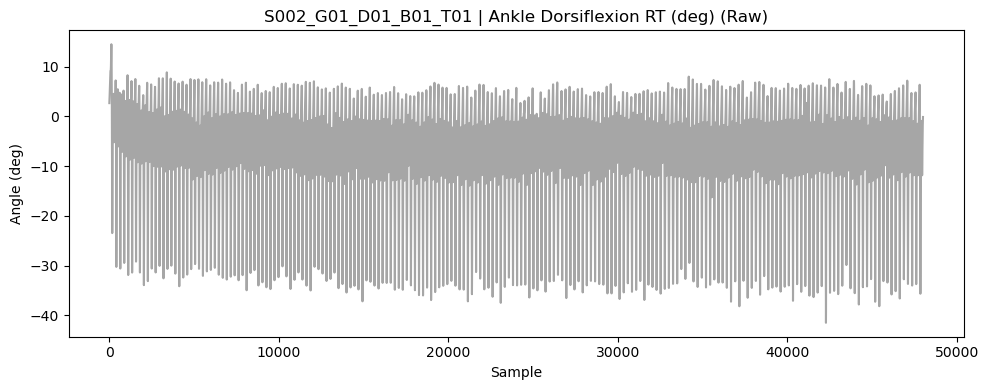

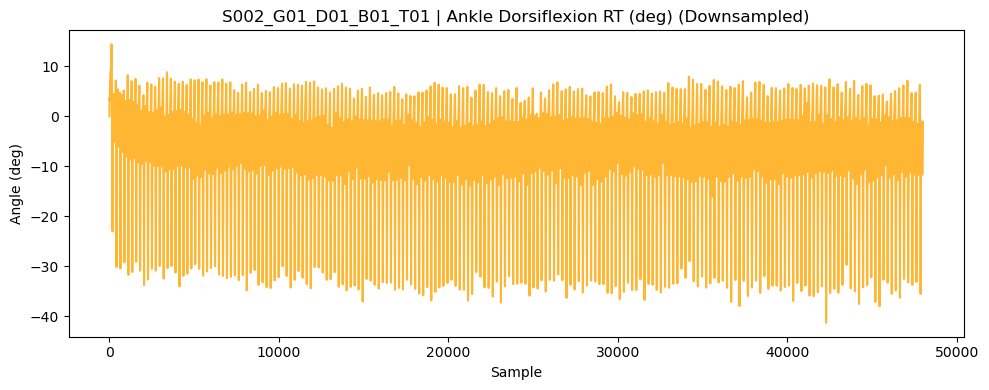

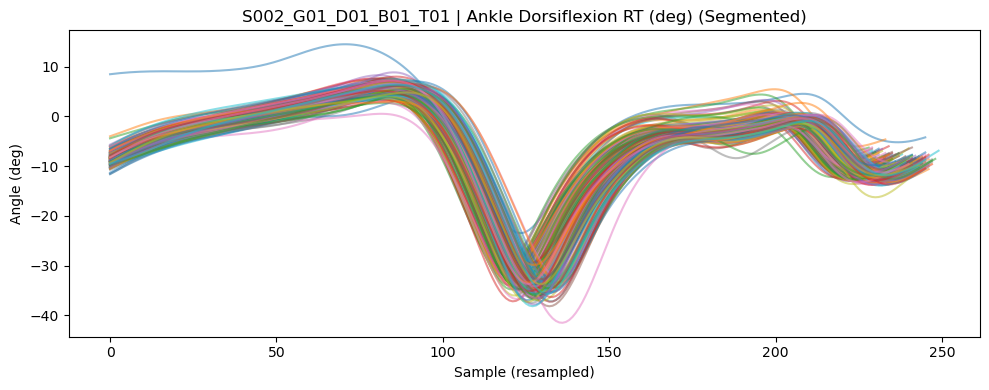

In [4]:
#Just one result
plot_trial(
        patient_id=patient_id,
        group_code=group_code,
        day=day,
        block=block,
        trial=trial,
        show_raw=show_raw,
        show_downsampled=show_downsampled,
        show_segmented=show_segmented,
        save_plots=save_plots
)

In [19]:
#To compare results 
signal_col        = "Ankle Dorsiflexion RT (deg)"
downsample_factor = 4
show_raw          = True
show_downsampled  = True
show_segmented    = True
save_plots        = False

batches = {
    "G01": {
        "S002": [
            {"trial": "T01", "day": "D01", "block": "B01"},
            {"trial": "T03", "day": "D01", "block": "B03"},
            
        ]
        
    },
    #"G03": {
        #"S139": [
            #{"trial": "T01", "day": "D01", "block": "B01"},
            
        #]
    #},
}


for group_code, patients in batches.items():
    for patient_id, trials in patients.items():
        for trial_info in trials:
            plot_trial(
                patient_id=patient_id,
                group_code=group_code,
                day=trial_info["day"],
                block=trial_info["block"],
                trial=trial_info["trial"],
                signal_col=signal_col,
                downsample_factor=downsample_factor,
                show_raw=show_raw,
                show_downsampled=show_downsampled,
                show_segmented=show_segmented,
                save_plots=save_plots
            )



[INFO] File Path: /home/dmartinez/Gait-Stability/young adults (19–35 years old)/S002/S002_G01_D01_B01_T01.csv


[INFO] File Path: /home/dmartinez/Gait-Stability/young adults (19–35 years old)/S002/S002_G01_D01_B03_T03.csv
